## Time series ##

First Loading the requried pacakges for the task

In [7]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import warnings
from statsmodels.tsa.arima_model import ARIMA
from pandas.core import datetools
import pandas.tseries

## Air Passengers Data Set ##

Loading the dataset 'Air Passengers' data

Coverting the first column 'Month' to the index

Dividing the data into train and validation based on the time.

In [8]:
data=pd.read_csv("data2.csv")
data['Month']=pd.to_datetime(data['Month'],format='%Y-%m-%d')
data.set_index(['Month'],inplace=True)
train_data = data['1949-01-01':'1959-12-01']
validation_data = data['1960-01-01':'1960-12-01']
data1=data

Plotting the data. 

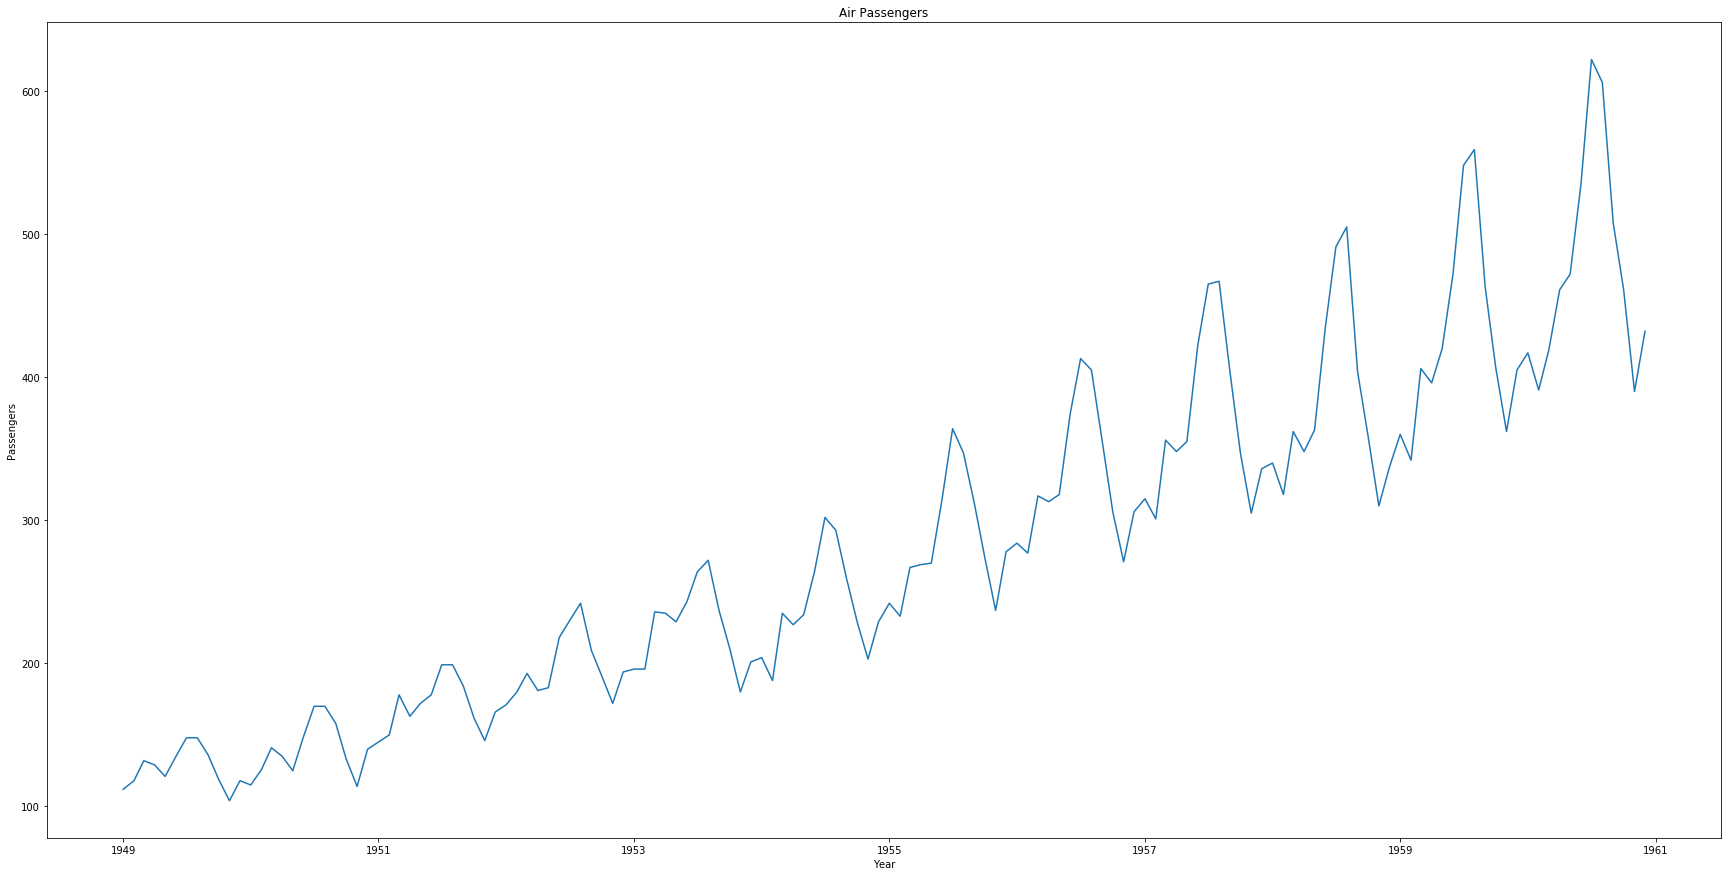

In [10]:
plt.figure(figsize=(30,15))
plt.plot(data)
plt.title('Air Passengers')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.show()

Defining the function stationary check which will check if a time series is stationary or not.

There are many ways to check this
    Firt data is divided into two halves and the mean and the standard deviation are calculated.
    If the mean and sd differ by large variation then they are not stationary.
    Then the time seires should be converted to statinary
    
The other method is by performing Augmented Dickey-Fuller test. In this test if we get the p-value less than 0.5 then that time seires is stationay else it is not.

The stationary chech function works as follows. 
    
    The rolling_mean is calculated for 12 months
    
    The stadard deviation is calculated for 12 months
    
    The plot with data, rolling mean and the standard deviation is made and plotted.
    
    The data is divided into 2 parts
    
    The mean of the 2 parts is calculated
    
    The standard deviation of the 2 parts is also calculated.
    
    The Dickey Fuller test is perfromed on the dataset

In [4]:
def stationary_chech(data):
    rolling_mean=data.rolling(window=12).mean()
    rolling_std=data.rolling(window=12).std()
    plt.figure(figsize=(30,15))
    data_plot=plt.plot(data,color='red',label='original')
    mean=plt.plot(rolling_mean,color='blue',label='rolling mean')
    std=plt.plot(rolling_std,color='green',label='rolling std')
    plt.legend()
    data=data.values
    mid=len(data)/2
    data1=data[0:int(mid)]
    data2=data[int(mid):]
    mean_data1=data1.mean()
    mean_data2=data2.mean()
    std1=data1.std()
    std2=data2.std()
    print("Mean of first part of data:",mean_data1,"\nMean of second part of data",mean_data2)
    print("Standard deviation of first part of data:",std1,"\nStandard deviation of second part of data",std2)
    df_test=adfuller(data)
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print (df_output)
    plt.show()

Mean of first part of data: 182.902777778 
Mean of second part of data 377.694444444
Standard deviation of first part of data: 47.371803534 
Standard deviation of second part of data 85.8368347002
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


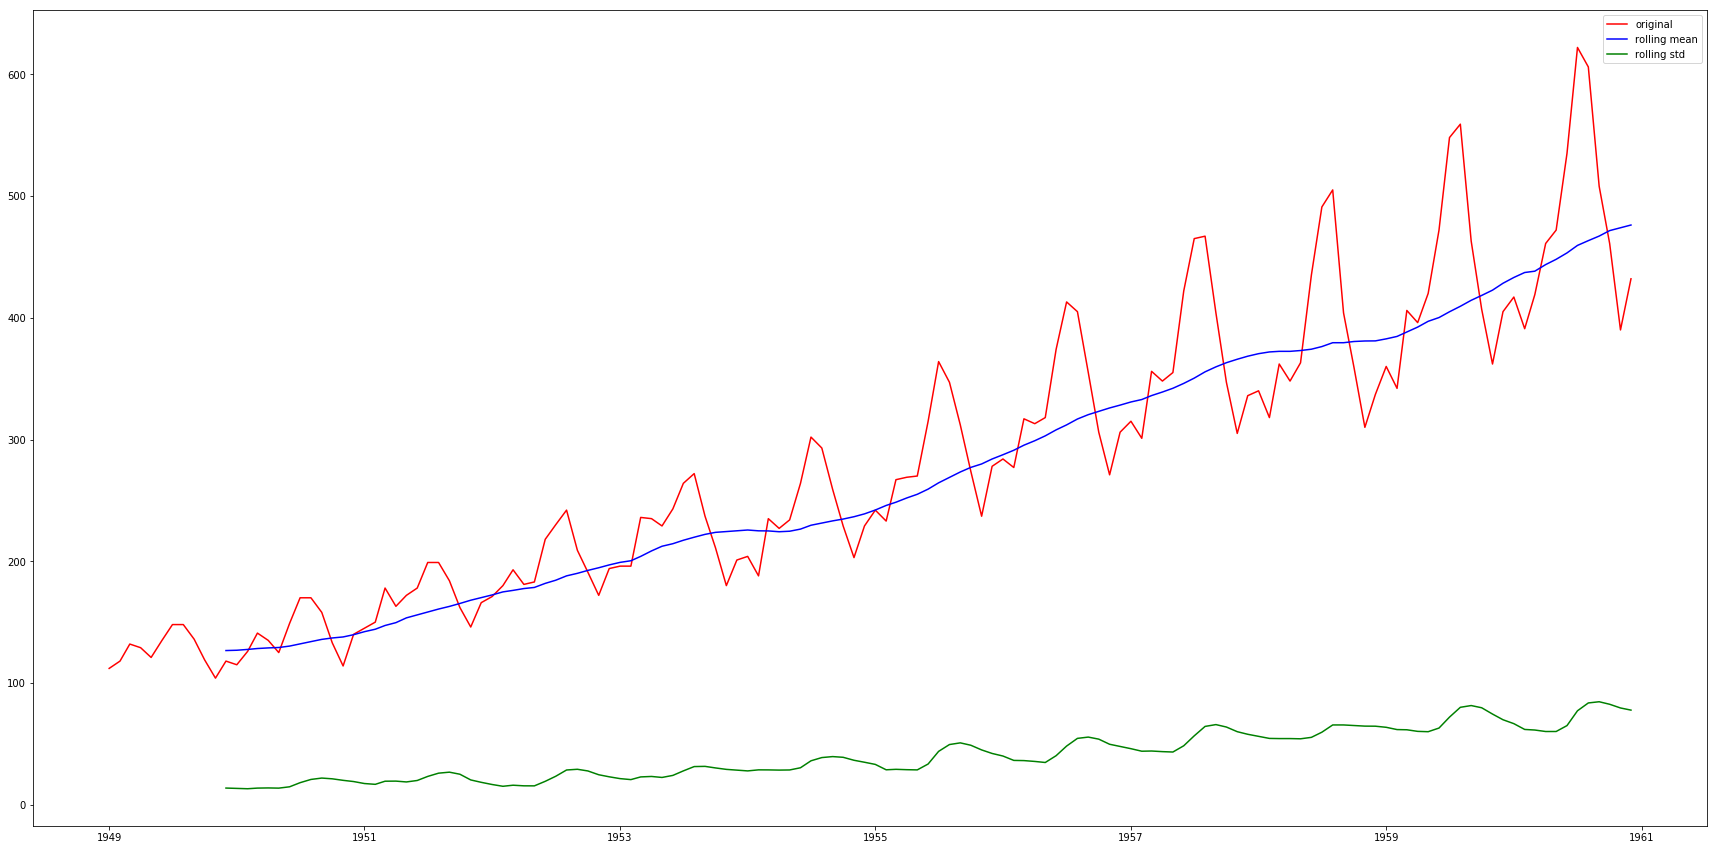

In [5]:
stationary_chech(data.Passengers)

If we observe the above values the mean of the first part and the second part vary on large scale so we can say that the time series is not stationary.

Even the negative p-value in the Dickey Fuller test states that time series is not stationary.

For this we will define a function called make_stationary which will make the data stationary by removing the seasonality and then the stationarity of the data is tested. 

In [6]:
def make_stationary(data):
    data['firstdiff']=data.Passengers-data.Passengers.shift(1)
    data['seasonaldiff']=data.Passengers-data.Passengers.shift(12)
    data['seasonal_firstdiff']=data.firstdiff-data.firstdiff.shift(12)
    stationary_chech(data.seasonal_firstdiff.dropna(inplace=False))
    

Mean of first part of data: 0.738461538462 
Mean of second part of data -0.363636363636
Standard deviation of first part of data: 10.4267067197 
Standard deviation of second part of data 13.895318989
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


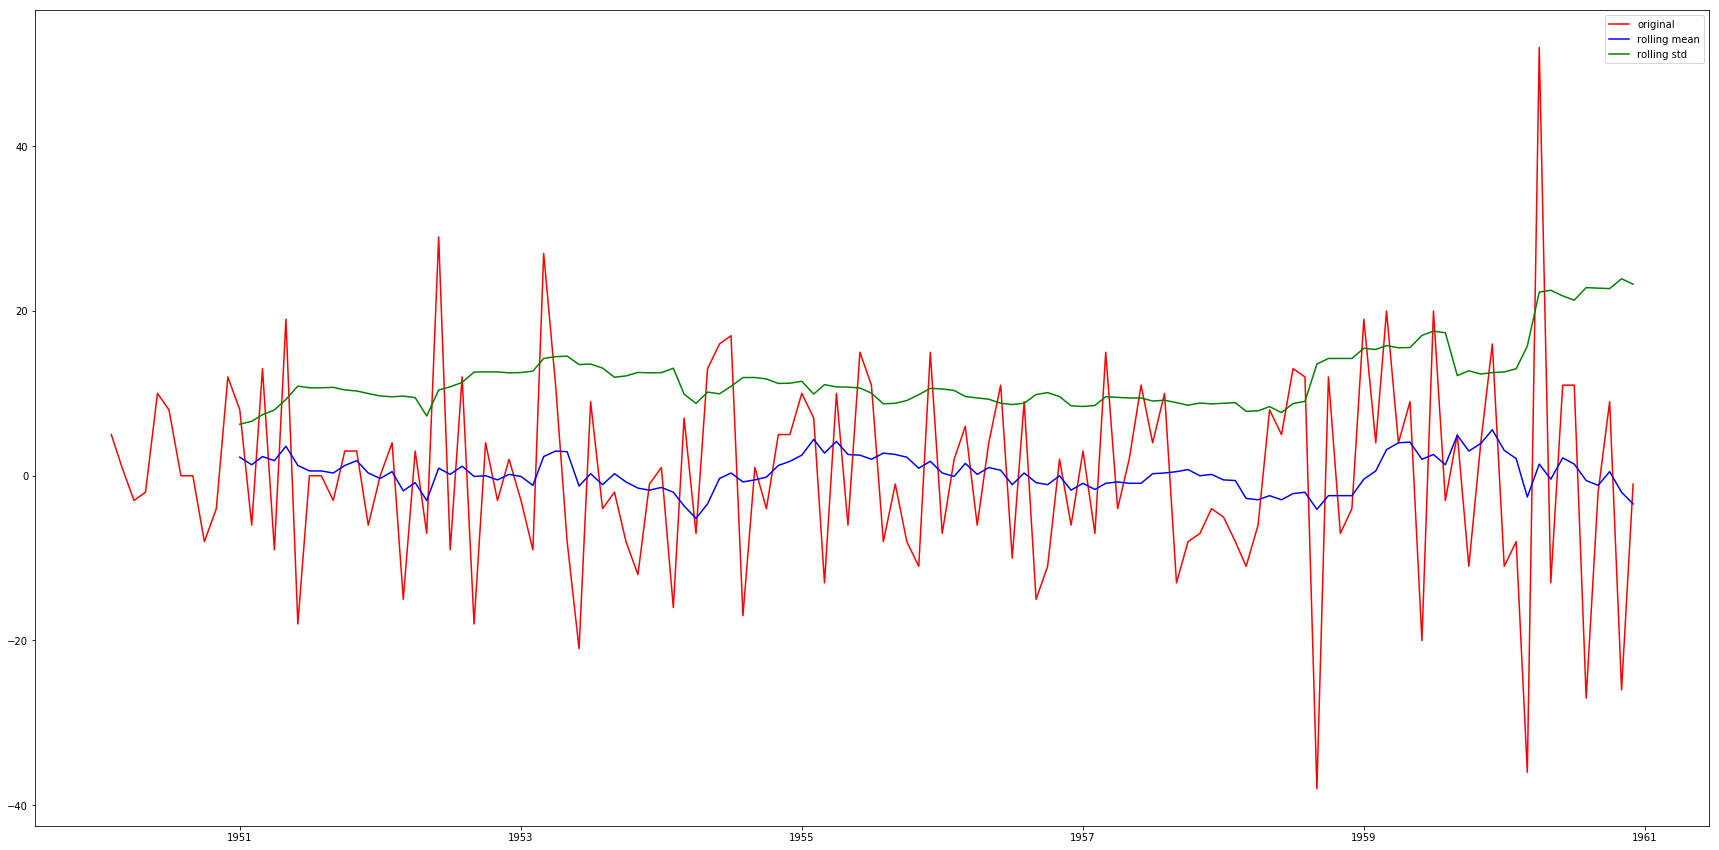

In [22]:
make_stationary(data)

If we observe the above results there is no big difference or variations in the mean

The p-value is also lessthan 0.5 when the DF test is performed and the graph doesn't show any seasonality.

In [8]:
def get_values(p,d,q):
    P=range(0,p)
    Q=range(0,q)
    D=range(0,d)
    pdq=list(itertools.product(P,D,Q))
    new_pdq=[ each+(12,) for each in pdq]
    return new_pdq,pdq

warnings.filterwarnings("ignore") # specify to ignore warning messages
s_pdq,pdq=get_values(4,2,2)
model_aic = []
models = []
for p in pdq:
    for p_season in s_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,order=p,seasonal_order=p_season,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            model_aic.append(results.aic)
            models.append([p, p_season])
        except:
            continue

As the data set has seasonality SARIMAX is used for developing the model.

The seasonlity is taken as 12 and the grid search is performed on the parameters p , d, q and seasonal parameters p,d,q and s and the best parameters 
are chosen for training the model and testing model.

After chosing the parameters the model is trained and then forecast is made.

The plots are made on the forecast and the original data and the accuracy is measured.

In [16]:
print("The ARIMA parameters p:",models[model_aic.index(min(model_aic))][0][0],"d:",models[model_aic.index(min(model_aic))][0][1],"q :",models[model_aic.index(min(model_aic))][0][2])
print("The Seasonal ARIMA parameters P:",models[model_aic.index(min(model_aic))][1][0],"D:",models[model_aic.index(min(model_aic))][1][1],"Q:",models[model_aic.index(min(model_aic))][1][2])
print("The best model",min(model_aic))
model= sm.tsa.statespace.SARIMAX(train_data,
                                order=models[model_aic.index(min(model_aic))][0],
                                seasonal_order=models[model_aic.index(min(model_aic))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit=model.fit()

The ARIMA parameters p: 3 d: 1 q : 0
The Seasonal ARIMA parameters P: 3 D: 1 Q: 1
The best model 618.205512334


In [17]:
predictions= model_fit.get_forecast('1960-12-01')
print(predictions.predicted_mean['1960-01-01':'1960-12-01'])

1960-01-01    419.493631
1960-02-01    397.831509
1960-03-01    460.856867
1960-04-01    449.448819
1960-05-01    474.553210
1960-06-01    537.847585
1960-07-01    614.883506
1960-08-01    628.208331
1960-09-01    519.333820
1960-10-01    462.252152
1960-11-01    412.161090
1960-12-01    452.661139
Freq: MS, dtype: float64


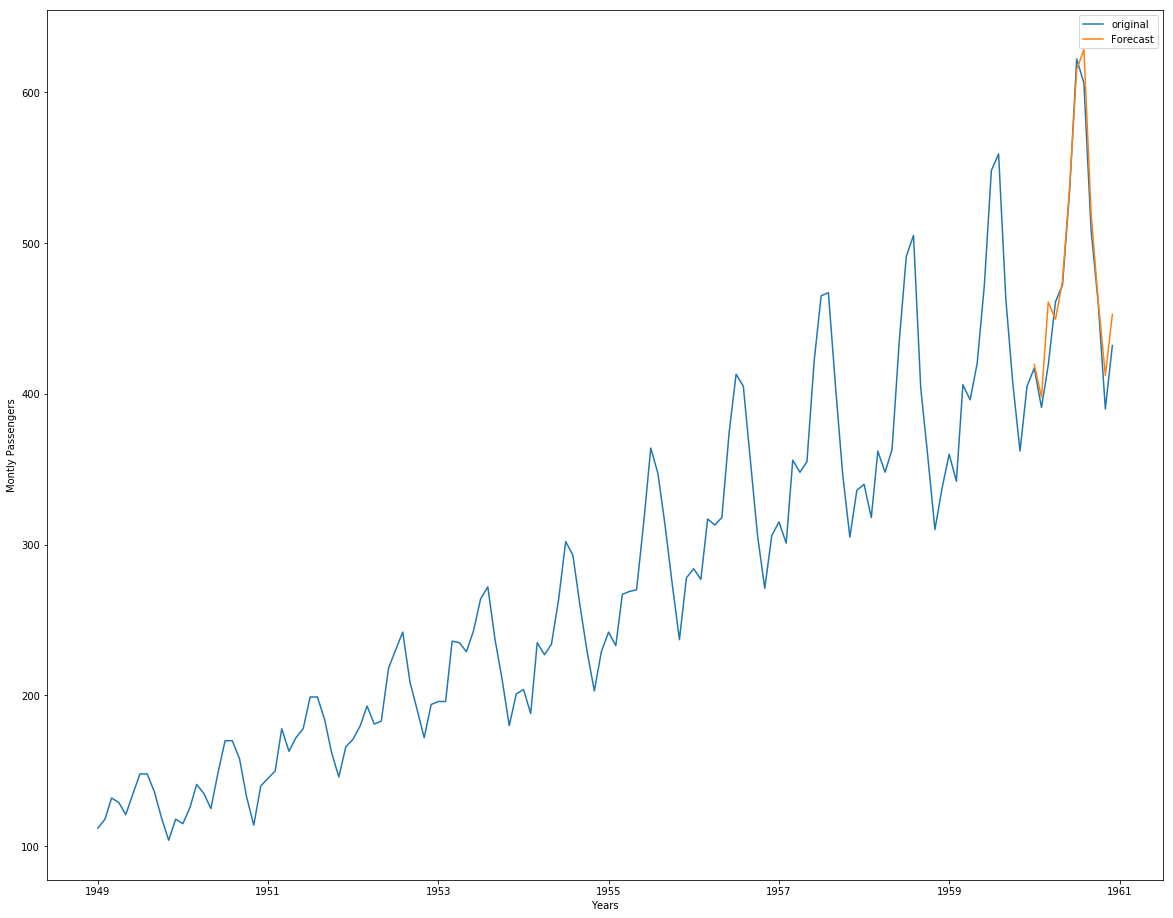

In [25]:
plt.figure(figsize=(20, 16))
plt.plot(data1,label='original')
plt.plot(predictions.predicted_mean, label='Forecast')
plt.xlabel("Years")
plt.ylabel("Montly Passengers")
plt.legend()
plt.show()

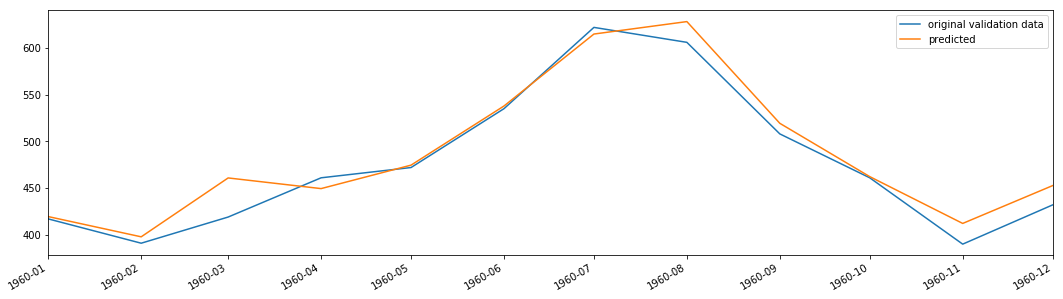

In [26]:
plt.figure(figsize=(18,5))
plt.plot(validation_data,label="original validation data")
predictions.predicted_mean['1960-01-01':'1960-12-01'].plot(label="predicted")
plt.legend()
plt.show()

In [27]:
predicted_values=predictions.predicted_mean.values
validated_values=validation_data.Passengers.values
np.sqrt(np.mean((predicted_values-validated_values)**2))

17.187245320475341

The RMSE is calculated for the validation set and it is 17.187245

## Melbourne Data Set ##

Load the Melbourne data set

Making the Date Column as index for the dataset.

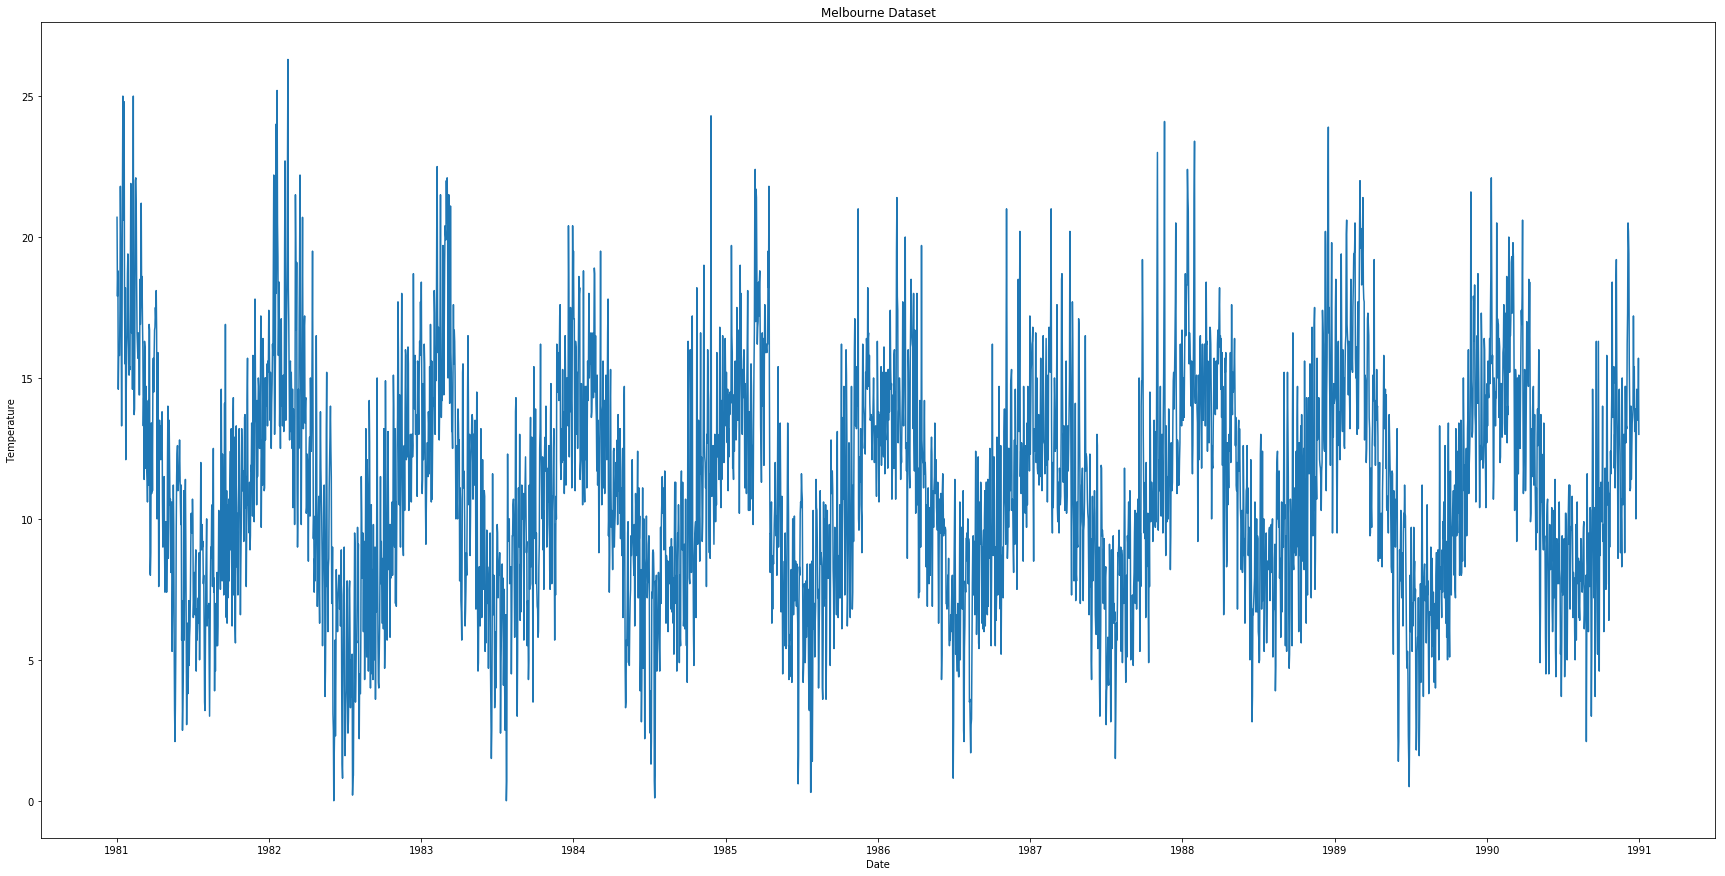

In [17]:
Data2=pd.read_csv("data1.csv")
Data2.fillna(0)
Data2['Date']=pd.to_datetime(Data2['Date'],format='%Y-%m-%d')
Data2.set_index(['Date'],inplace=True)
plt.figure(figsize=(30,15))
plt.plot(Data2)
plt.title("Melbourne Dataset")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()

Mean of first part of data: 11.0435068493 
Mean of second part of data 11.312
Standard deviation of first part of data: 4.26155194293 
Standard deviation of second part of data 3.86700884016
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


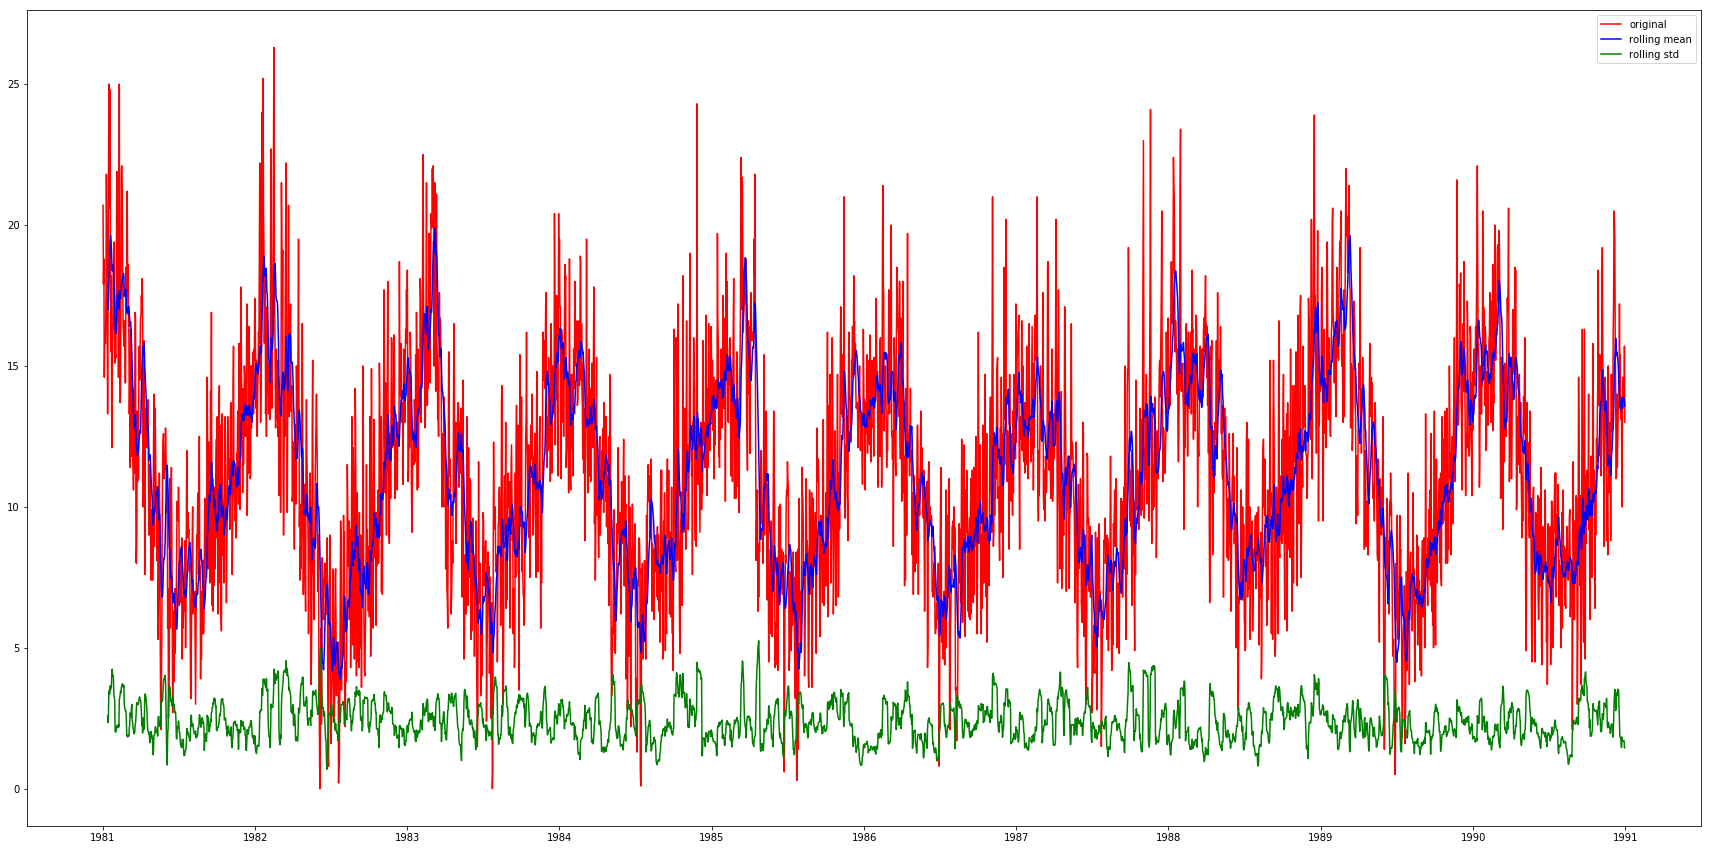

In [11]:
stationary_chech(Data2.Temp)

Checking the Stationarity of the time series

The means of the two halves of data is calculated

The means doesn't differ so much. 

The DF test also shows that the time series is stationary. 

The p-value is lessthan 0.5

The data is divided into train and validation based on the dates

In [30]:
train = Data2['1981-01-01':'1989-12-31']
validation= Data2['1990-01-01':'1990-12-31']

The p, d, q values are generated and grid search is performed to get the best p, d and q values 

Once the best parameters are obtained the model is trained on the parameters and then the forecast is made

The plots are made with the forecasts and the rmse is calculated

In [31]:
models=[]
model_aic=[]
s_pdq,pdq=get_values(5,2,2)
for each in pdq:
    model=ARIMA(train,order=each)
    results=model.fit()
    print("model with :",each," has AIC:",results.aic)
    models.append(each)
    model_aic.append(results.aic)
print("The best model is p:",models[model_aic.index(min(model_aic))][0]," q:",models[model_aic.index(min(model_aic))][1],"d:",models[model_aic.index(min(model_aic))][0])
print("AIC :",min(model_aic))

model with : (0, 0, 0)  has AIC: 18581.8831685
model with : (0, 0, 1)  has AIC: 16735.718262377908
model with : (0, 1, 0)  has AIC: 15961.1847818
model with : (0, 1, 1)  has AIC: 15665.764944666369
model with : (1, 0, 0)  has AIC: 15577.566181076158
model with : (1, 0, 1)  has AIC: 15531.697003130343
model with : (1, 1, 0)  has AIC: 15849.641586322092
model with : (1, 1, 1)  has AIC: 15190.940359890996
model with : (2, 0, 0)  has AIC: 15558.080200205932
model with : (2, 0, 1)  has AIC: 15187.986174812957
model with : (2, 1, 0)  has AIC: 15620.663992660528
model with : (2, 1, 1)  has AIC: 15147.953971141924
model with : (3, 0, 0)  has AIC: 15439.69680169626
model with : (3, 0, 1)  has AIC: 15144.051057326862
model with : (3, 1, 0)  has AIC: 15498.611753791967
model with : (3, 1, 1)  has AIC: 15149.915333456232
model with : (4, 0, 0)  has AIC: 15372.26850760437
model with : (4, 0, 1)  has AIC: 15146.044086992782
model with : (4, 1, 0)  has AIC: 15408.647513875983
model with : (4, 1, 1)  

In [32]:
v=models[model_aic.index(min(model_aic))]
model=ARIMA(train,order=v)
model_fit=model.fit(disp=0)
predictions=model_fit.predict(start=3284,end=3648)

In [33]:
vali_val=validation.Temp.values
predicitons_val=predictions.values

In [34]:
print("RMSE for the validation",np.sqrt(np.mean((vali_val-predicitons_val)**2)))

RMSE for the validation 3.69205616048


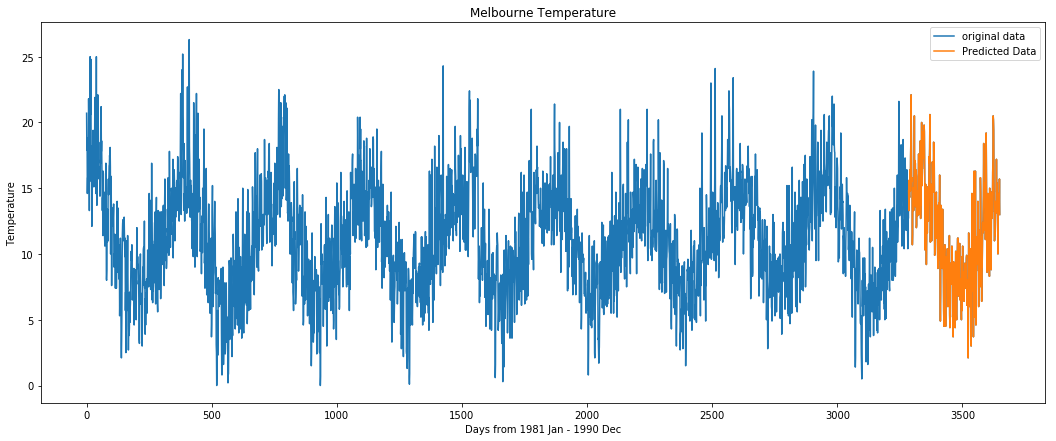

In [37]:
plt.figure(figsize=(18,7))
pltval=Data2.Temp.values
plt.plot(pltval,label="original data")
plt.plot(range(len(train),len(Data2)),vali_val,label="Predicted Data")
plt.legend()
plt.xlabel("Days from 1981 Jan - 1990 Dec")
plt.ylabel("Temperature")
plt.title("Melbourne Temperature")
plt.show()

The plot is made for the forecasted data and the original data 